<a href="https://colab.research.google.com/github/Morax19/ML_UCV/blob/main/Tarea2/Tarea2_ML_DanielHernandez_Parte1_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



TAREA 2: APRENDIZAJE SUPERVISADO<br>
Aprendizaje Automático, Escuela de Computación, Facultad de Ciencias - UCV
<br>
<br>
#Parte 2: Reconocimiento de Operadores
<br>
<br>
Autor: Daniel Hernández<br>
Fecha: 15 de Febrero 2025



## Introducción

---

La función principal de este notebook es hacer uso de 3 modelos de Aprendizaje Automático con el objetivo de reconocer de operadores matemáticos escritos a mano, cada modelo tendrá su sección correspondiente con cada paso realizado debidamente justificado, para finalizar, se hará una comparación entre diferentes métricas que nos den permitan medir el rendimiento de cada modelo.

En esta sección se muestran los pasos iniciales tales como la importación de librerías, descarga y pre-procesamiento del conjunto de datos.


### Configuración del entorno

Lo primero que se define es el valor de la semilla a utilizar a lo largo del notebook, con la finalidad de poder reproducir los resultados.

In [1]:
#El valor de la semilla viene definido previamente
SEED = 27795163

Se importan las librerias necesarias:

In [2]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV

### Pre-procesamiento


Para este notebook, lo primero que se hizo fue construir el conjunto de datos, para esto se hizo uso de la aplicación [MediBang Paint](https://medibangpaint.com/es/). Dado que en la parte anterior se trabajó con MNIST, se intentó construir un conjunto de datos que siguiera los mismos estándares de forma que se maximice la consistencia, en ese orden de ideas, se realizaron imágenes de dimensiones 28 píxeles de alto y largo, con un fondo negro y operadores trazados en blanco.

El resultado es el [Dataset Operadores](https://github.com/HandlessCoder/Dataset_Operadores_28x28/), el cual contiene imágenes correspondientes a los siguientes operadores matemáticos:
* Suma (+)
* Resta (-)
* Multiplicación (*) (×)
* División (/) (÷)

#### Import de los datos

Lo primero que debemos hacer es clonar el repositorio donde se encuentran las imágenes que vamos a utilizar.

In [3]:
!git clone https://github.com/HandlessCoder/Dataset_Operadores_28x28.git

fatal: destination path 'Dataset_Operadores_28x28' already exists and is not an empty directory.


Como paso siguiente, navegaremos a la rama donde se encuentran las imágenes correspondientes a los operadores.

In [4]:
%cd Dataset_Operadores_28x28/

/content/Dataset_Operadores_28x28


In [5]:
!git checkout prueba

Switched to branch 'prueba'
Your branch is up to date with 'origin/prueba'.


#### Armado del Dataset

Procedemos entonces a cargar todas las imágenes a nuestro notebook, para esto primero se hace import del módulo [os](https://docs.python.org/es/3.10/library/os.html) y se define la función load_images.

In [6]:
import os
from PIL import Image

def load_images(root, label):
    images = []
    labels = []

    for filename in os.listdir(root):
        img = Image.open(os.path.join(root, filename)).convert("L")
        img = img.resize((28, 28))  #Se asegura que cada imagen tenga las dimensiones adecuadas
        img_np = np.array(img)  #Se lleva la imagen a un arregla de NumPy
        images.append(img_np)
        labels.append(label)
    return np.array(images), np.array(labels)

Posteriormente se tiene:

In [7]:
#Se define la ruta donde están las imagenes de operadores
root = "/content/Dataset_Operadores_28x28/"

#Dado que cada operador tiene una carpeta con las imágenes correspondientes, se cargan por separado

img_suma, label_suma = load_images(root+"Suma", ord('+'))               #Suma
img_resta, label_resta = load_images(root+"Resta", ord('-'))            #Resta
img_div1, label_div1 = load_images(root+"Division1", ord('/'))          #División1 -> /
img_div2, label_div2 = load_images(root+"Division2", ord('÷'))          #División2 -> ÷
img_mult1, label_mult1 = load_images(root+"Multiplicacion1", ord('*'))  #Multiplicación1 -> *
img_mult2, label_mult2 = load_images(root+"Multiplicacion2", ord('×'))  #Multiplicación2 -> ×

#Para armar el conjunto de datos, se concatenan las imagenes y sus respectivas etiquetas
img_total = np.concatenate((img_suma, img_resta, img_div1, img_div2, img_mult1, img_mult2), axis = 0)
label_total = np.concatenate((label_suma, label_resta, label_div1, label_div2, label_mult1, label_mult2), axis = 0)

Es necesario separar los datos en grupos de entrenamiento y prueba, en nuestro caso se hará uso de un 80% entrenamiento y un 20% prueba.

Adicional a esto, es necesario vectorizar los valores en X, es decir, aplanar las imágenes originales en un vector de 784 elementos y normalizar sus valores para poder trabajar con los mismos.

In [8]:
#Se separan los datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(img_total, label_total, test_size = 0.1, random_state = SEED)

#Se vectorizan las imágenes almacenadas en X
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

#Se normalizan los valores X
X_train = X_train / 255.0
X_test = X_test / 255.0

#Finalmente, podemos tener una vista previa de los datos con los que vamos a trabajar
print(f"Cantidad de imágenes para entrenamiento: {X_train.shape[0]}")
print(f"Cantidad de imágenes de prueba: {X_test.shape[0]}")

Cantidad de imágenes para entrenamiento: 562
Cantidad de imágenes de prueba: 63


##   1. Regresión Logística

Nuestro objetivo principal es, dada una imagen, determinar a que operador matemático corresponde la misma. Es por esto que nos encontramos ante un problema de clasificación, para resolcerlo, el primer modelo que vamos a utilizar será [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) el cual nos va a permitir clasificar la imagen vista según una probabilidad calculada.

---



### 1.1. Import

Se importa el modelo desde SciKitLearn

In [9]:
from sklearn.linear_model import LogisticRegression

### 1.2.  Métricas

Es importante que conozcamos los hiperparámetros del modelo que vamos a utilizar, ya que ajustar estos nos va a permitir modificar su comportamiento y obtener el mejor rendimiento posible del mismo.

Antes de continuar, es importante que definamos:

* Regularización: Consiste en añadir ruido a los coeficientes de nuestro modelo con la finalidad de evitar el sobreajuste, es decir, que se memoricen los datos en lugar de aprenderlos. Esto ayuda a que nuestro modelo se ajuste mejor a datos que aún le son desconocidos.

Teniendo esto claro, los hiperparámetros que debemos ajustar para el modelo de Regresión Logística son los siguientes:

* C: Establece la fuerza de regularización que se ejerce sobre los coeficientes de nuestro modelo.
* penalty: Define que tipo de regularización se aplica al modelo.
* solver: Especifica el algoritmo utilizado para optimizar la función de pérdida.
* max_iter: Establece el máximo de iteraciones realizadas por el solver para converger.

In [10]:
#Se usa este objeto para definir los posibles valores de cada hiperparámetro
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg']
}

Previo al entrenamiento del modelo debemos definir lo que es la validación cruzada, proceso que consiste en dividir los datos definidos para entrenamientos en K grupos, luego se utilizan K-1 grupos para entrenar el modelo y el grupo restante para validación, cabe destacar que este proceso se repite para todas las combinaciones posibles de los K grupos.

La importancia de hacer esto radica en lograr que nuestro modelo generalice correctamente y tenga un buen rendimiento sobre datos que le son desconocidos.

Para tener una idea del rendimiento de nuestro modelo, haremos uso de las siguientes métricas:

* Accuracy: También llamado precisión o exactitud, representa el porcentaje de predicciones acertadas.
* Precision: Representa la proporción de predicciones positivas acertadas entre el total de predicciones positivas.
* Recall: Conocido también como exhaustividad, mide la proporción de predicciones positivas identificadas, ya sean verdaderos positivos o falsos negativos.
* F1 Score: Es la media armónica entre Precision y Recall, es una medida útil cuando no se esta seguro de que todas las clases tengan la misma cantidad de elementos.

Se hace uso de GridSearchCV para estimación de parámetros y cálculo de scores en validación cruzada

In [11]:
#Se calculan diferentes metricas para medir el rendimiento del modelo
grid_search_LR = GridSearchCV(LogisticRegression(max_iter = 10000), param_grid_LR, cv = 5, scoring = 'accuracy')

#Do not disturb... Machine is Learning
grid_search_LR.fit(X_train, y_train)

#Resultados
print(f"Resultados obtenidos:")
print(f"Hiperparámetros encontrados: {grid_search_LR.best_params_}\n")

print(f"Métricas del modelo:")
print(f"Accuracy: {grid_search_LR.best_score_ * 100:.2f}%")

Resultados obtenidos:
Hiperparámetros encontrados: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

Métricas del modelo:
Accuracy: 90.57%


Resultados obtenidos:

### 1.3. Pruebas

Se obtiene el mejor modelo y se utiliza el conjunto de datos de prueba para realizar predicciones con el fin observar su comportamiento.

In [12]:
#Se guarda el mejor modelo obtenido de GridSearchCV()
modelLR = grid_search_LR.best_estimator_

#Primeras pruebas con el modelo
start_time_LR = time.time()
y_pred_LR = modelLR.predict(X_test)
end_time_LR = time.time()

#Tiempo que toma realizar una predicción
pred_time_LR = end_time_LR - start_time_LR

#Se calcula la precisión obtenida
acc_pred_LR = accuracy_score(y_test, y_pred_LR)

#Se calcula la matriz de confusión asociada
conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)

Resultados obtenidos:

In [13]:
print(f"Predicciones: {y_pred_LR}\nValores Reales: {y_test}\n")
print(f"Precisión de la predicción: {acc_pred_LR * 100:.2f}%")

Predicciones: [ 43  42  45  42  45  45 215  42  47 215  47  42  43 247  42 215  47  43
  43  47  47  43  43 247  45  47  47  45  47  43  43  42  43  43  42  45
  42 247  42 247  47  45  45  42 215 215  47 247  45  43  45 215 247  45
  42  45  42  47  47  47  45  47  43]
Valores Reales: [ 43  42  45  42  45  45 215  42  47 215  47  42  43 247  42 215  47  43
  43  45  47  43  43 247  45 215  47  45  47  43  43  42  43  43  42  45
  42 247  42 247 215  45  45  42 215 215  47 247  45  43  45 215 247  42
  42 215  42  47  47  47  45  47  43]

Precisión de la predicción: 92.06%


### 1.4. Resultados generales

A continuación se muestra la matriz de confusión correspondiente al modelo, usando esta herramienta resulta más intutivo entender los resultados obtenidos.

La diagonal principal nos muestra las predicciones acertadas por cada operador, mientras que las demás celdas indican la cantidad de veces que se obtuvo como resultado de la predicción uno diferente al correcto.

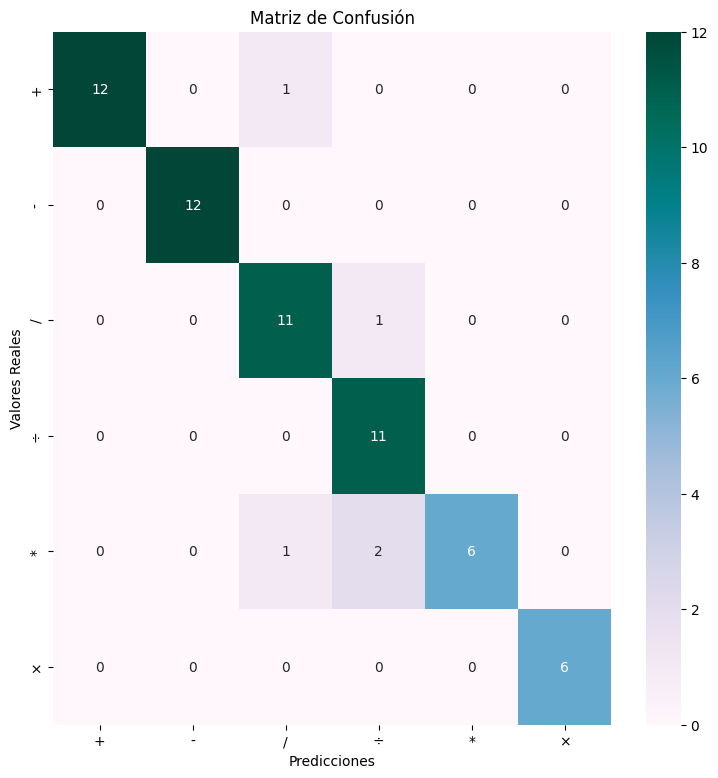

In [14]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_LR, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = ['+', '-', '/', '÷', '*', '×'],
    yticklabels = ['+', '-', '/', '÷', '*', '×']
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Por último, se selecciona una muestra aleatoria de 8 imágenes de entre el conjunto de prueba y se muestran los valores de predicción del modelo junto al valor real correspondiente.

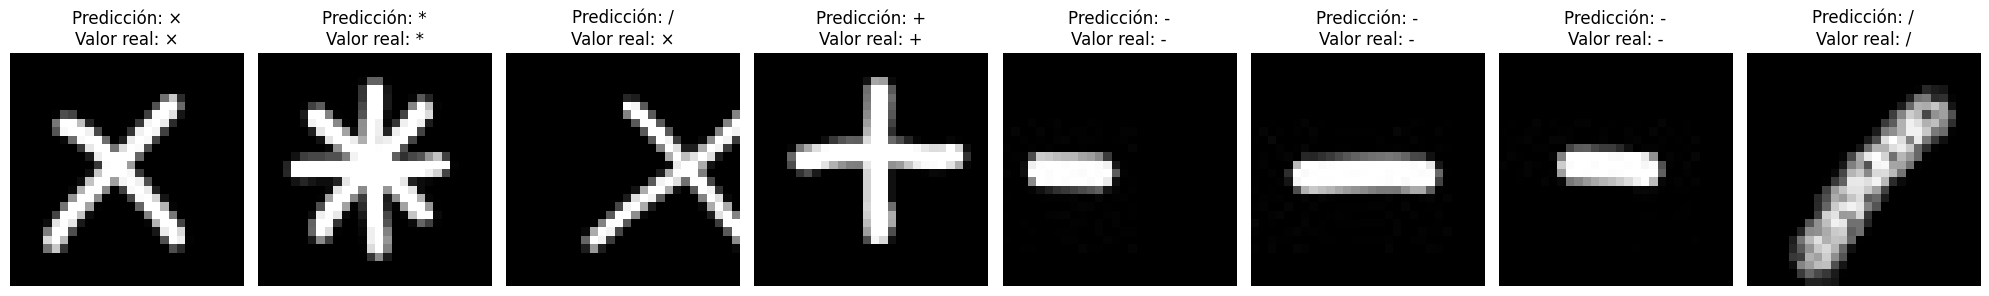

In [15]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {chr(y_pred_LR[index])}\nValor real: {chr(y_test[index])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. K-Vecinos

El segundo modelo que vamos a utilizar corresponda a [K-Nearest Neighbors (KNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) también conocido como K-Vecinos o K-Vecinos más cercanos. Este modelo almacena los datos y establece distancias entre ellos, al presentarse un dato desconocido este lo asigna a la clase con la que su distancia sea menor, es bastante útil en tareas de clasificación como la que tenemos actualmente.

---

### 2.1. Import

Se importa el modelo de SciKitLearn.

In [16]:
from sklearn.neighbors import KNeighborsClassifier

### 2.2. Métricas

De manera similar al modelo anterior, KNN también posee hiperparámetros que debemos ajustar para tener el mejor rendimiento posible, estos son los siguientes:

* n_neighbors: Define el valor de K, es decir, el número de vecinos cercanos que se tendrán en cuenta al clasificar un dato nuevo, es el hiperparámetro más importante de este modelo.
* metric: Este define la forma en la que se entiende que tan cerca se encuentran dos puntos, es decir, como se va a medir la distancia entre puntos.
* weights: Controla el peso o influencia que tienen los vecinos al momento de clasificar un punto nuevo, todos los vecinos pueden tener la misma influencia o darle mayor importancia a los más cercanos


In [17]:
#Se definen los rangos de valores a estimar
param_grid_KNN = {
    'n_neighbors': range(2, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
    }

Las métricas mencionadas en Regresión Logística también aplican en este modelo, por lo que no se volverán a definir de forma explícita, sin embargo cabe mencionar que la métrica en la que nos enfocaremos será la precisión o accuracy. De igual manera se repetirá el uso de la validación cruzada para mejorar la generalización del modelo

In [18]:
#Se usa GridSearchCV para los calculos de los hiperparámetros y de los scores
grid_search_KNN = GridSearchCV(KNeighborsClassifier(), param_grid_KNN, cv = 5, scoring = 'accuracy')

#Shhhh... Machine is Learning (again)
grid_search_KNN.fit(X_train, y_train)

#Resultados
print(f"Resultados obtenidos:")
print(f"Hiperparámetros encontrados: {grid_search_KNN.best_params_}\n")

print(f"Métricas del modelo:")
print(f"Accuracy: {grid_search_KNN.best_score_ * 100:.2f}%")

Resultados obtenidos:
Hiperparámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}

Métricas del modelo:
Accuracy: 94.48%


### 2.3. Pruebas

Se obtiene el mejor modelo y se utiliza el conjunto de datos de prueba para realizar predicciones con el fin observar su comportamiento.

In [19]:
#Se guarda el mejor modelo obtenido de GridSearchCV()
modelKNN = grid_search_KNN.best_estimator_

#Primeras predicciones del modelo:
start_time_KNN = time.time()
y_pred_KNN = modelKNN.predict(X_test)
end_time_KNN = time.time()

#Tiempo que toma realizar una predicción
pred_time_KNN = end_time_KNN - start_time_KNN

#Se calcula la precisión obtenida
acc_pred_KNN = modelKNN.score(X_test, y_test)

#Se calcula la matriz de confusión asociada
conf_matrix_KNN = confusion_matrix(y_test, y_pred_KNN)

Resultados obtenidos de la predicción y la precisión de la misma:

In [20]:
print(f"Predicciones: {y_pred_KNN}\nValores Reales: {y_test}\n")
print(f"Precisión de la predicción: {acc_pred_KNN * 100:.2f}%")

Predicciones: [ 43  42  45  42  45  45 215  43  47 215  47  42  43 247  42 215  47  43
  43  45  47  43  43 247  45  47  47  45  47  43  43  42  43  43  42  45
  42 247  42 247  47  45  45  42 215 215  47 247  45  43  45 215 247  45
  42  45  42  47  47  47  45  47  43]
Valores Reales: [ 43  42  45  42  45  45 215  42  47 215  47  42  43 247  42 215  47  43
  43  45  47  43  43 247  45 215  47  45  47  43  43  42  43  43  42  45
  42 247  42 247 215  45  45  42 215 215  47 247  45  43  45 215 247  42
  42 215  42  47  47  47  45  47  43]

Precisión de la predicción: 92.06%


### 2.4. Resultados generales

A continuación se muestra la matriz de confusión obtenida para este modelo, la interpretación de la misma es igual a la del modelo anterior. Con esta herramiento podremos observar a detalle el rendimiento del modelo en el conjunto de prueba.

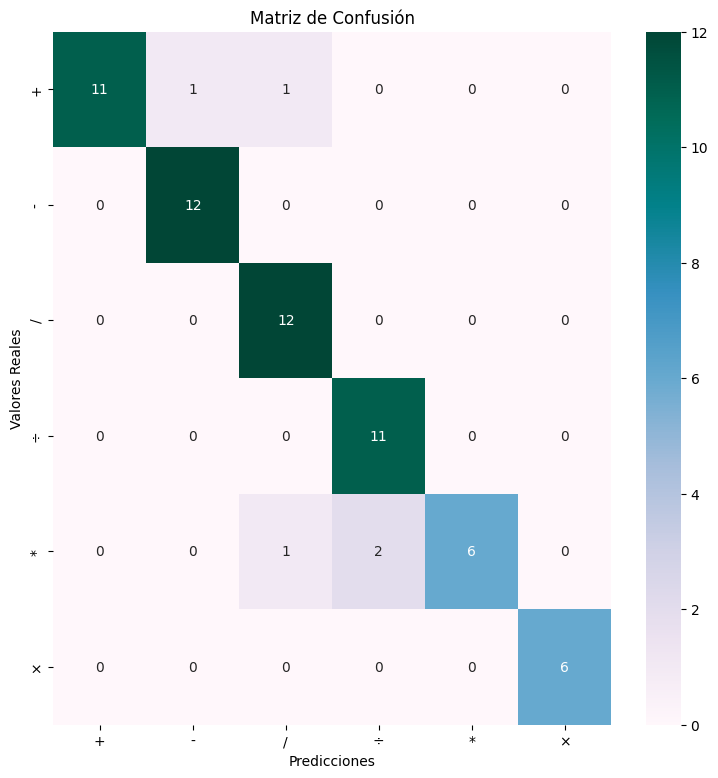

In [21]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_KNN, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = ['+', '-', '/', '÷', '*', '×'],
    yticklabels = ['+', '-', '/', '÷', '*', '×']
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

De igual forma, se toma una muestra aleatoria de 8 imágenes del conjunto de prueba y se muestran los valores de la predicción realizada por el modelo junto al valor real correspondiente a la imagen.

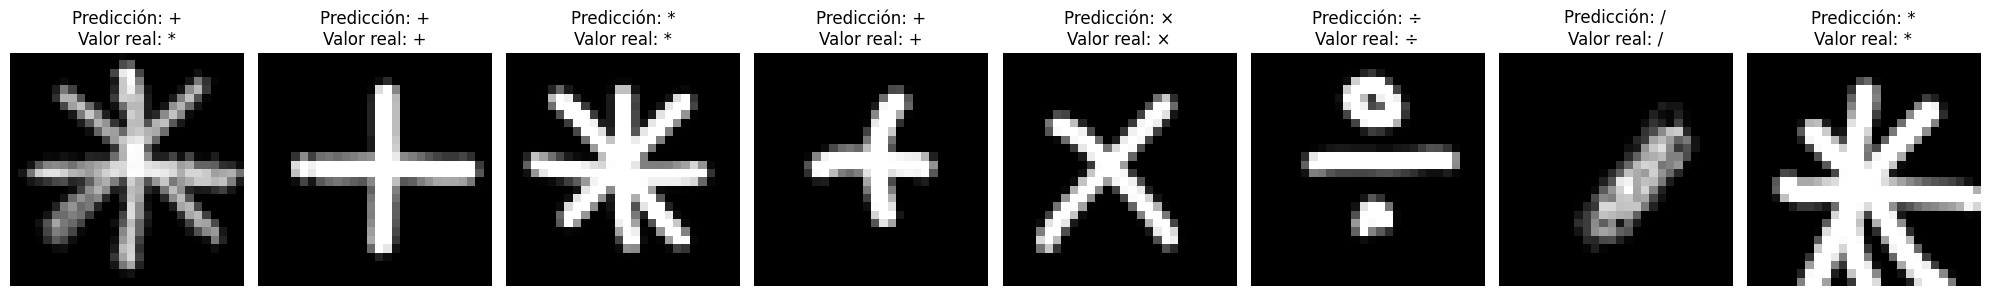

In [22]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {chr(y_pred_KNN[index])}\nValor real: {chr(y_test[index])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. SVM

El último modelo que usaremos en este notebook será [SVM](https://scikit-learn.org/stable/modules/svm.html) conocido como Máquinas de Vectores de Soporte o Máquinas de Soporte Vectorial. Este algoritmo se encarga de calcular el hiperplano que mejor separa los datos en las diferentes clases.

---

### 3.1. Import

Dad que estamos en un problema de clasificación, debemos hacer uso de la clase [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) de SVM en SciKitLearn.

In [23]:
from sklearn.svm import SVC

### 3.2. Métricas

De forma similar a los 2 modelos anteriores, se tienen un conjunto de hiperparámetros que debemos ajustar para obtener el mejor rendimiento posible del modelo. En el caso de SVM, son los siguientes:

* Kernel: Este define cómo se mapean los datos a un espacio de mayor dimensión donde sea posible encontrar un hiperplano lineal que separe las clases.
* C: Este parámetro se encarga de la regularización, su valor determina si se le da prioridad a maximizar el margen o a la clasificación correcta de los puntos de entrenamiento.
* gamma: Este parámetro solo aplica con kernels no lineales, controla el radio de influencia de cada punto.

In [24]:
#Se definen los rangos de valores a estimar
param_grid_SVM = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

Las métricas mencionadas en Regresión Logística y en KNN también aplican en este modelo, por lo que no se volverán a definir de forma explícita. En este caso se también vamos a enfocarnos en la precisión o accuracy.

Al mismo tiempo, se usará validación cruzada para conseguir que el modelo generalice de forma correcta.

In [25]:
grid_search_SVM = GridSearchCV(SVC(), param_grid_SVM, cv = 5, scoring = 'accuracy')

#Be quiet... Machine's Learnig over here
grid_search_SVM.fit(X_train, y_train)

#Resultados
print(f"Resultados obtenidos:")
print(f"Hiperparámetros encontrados: {grid_search_SVM.best_params_}\n")

print(f"Métricas del modelo:")
print(f"Accuracy: {grid_search_SVM.best_score_ * 100:.2f}%")

Resultados obtenidos:
Hiperparámetros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Métricas del modelo:
Accuracy: 95.37%


### 3.3. Pruebas

Se obtiene el mejor modelo y se utiliza el conjunto de datos de prueba para realizar predicciones con el fin observar su comportamiento.

In [26]:
#Se hace uso del mejor modelo obtenido de GridSearchCV()
modelSVM = grid_search_SVM.best_estimator_

#Primeras predicciones del modelo:
start_time_SVM = time.time()
y_pred_SVM = modelSVM.predict(X_test)
end_time_SVM = time.time()

#Tiempo que toma realizar una predicción
pred_time_SVM = end_time_SVM - start_time_SVM

#Se calcula la precisión obtenida
acc_pred_SVM = accuracy_score(y_test, y_pred_SVM)

#Se calcula la matriz de confusión asociada
conf_matrix_SVM = confusion_matrix(y_test, y_pred_SVM)

Resultados obtenidos de la predicción junto a la precisión de la misma:

In [27]:
print(f"Predicciones: {y_pred_SVM}\nValores Reales: {y_test}\n")
print(f"Accuracy: {acc_pred_SVM * 100:.2f}%")

Predicciones: [ 43  42  45  42  45  45 215  42  47 215  47  42  43 247  42 215  47  43
  43  45  47  43  43 247  45  47  47  45  47  43  43  42  43  43  42  45
  42 247  42 247  47  45  45  42 215 215  47 247  45  43  45 215 247  42
  42  47  42  47  47  47  45  47  43]
Valores Reales: [ 43  42  45  42  45  45 215  42  47 215  47  42  43 247  42 215  47  43
  43  45  47  43  43 247  45 215  47  45  47  43  43  42  43  43  42  45
  42 247  42 247 215  45  45  42 215 215  47 247  45  43  45 215 247  42
  42 215  42  47  47  47  45  47  43]

Accuracy: 95.24%


### 3.4. Resultados generales

Para SVM también nos resulta útil hacer uso de la matriz de confusión, ya que nos permite observar detalladamente el resultado de la predicción realizada y así comprender el comportamiento del modelo.

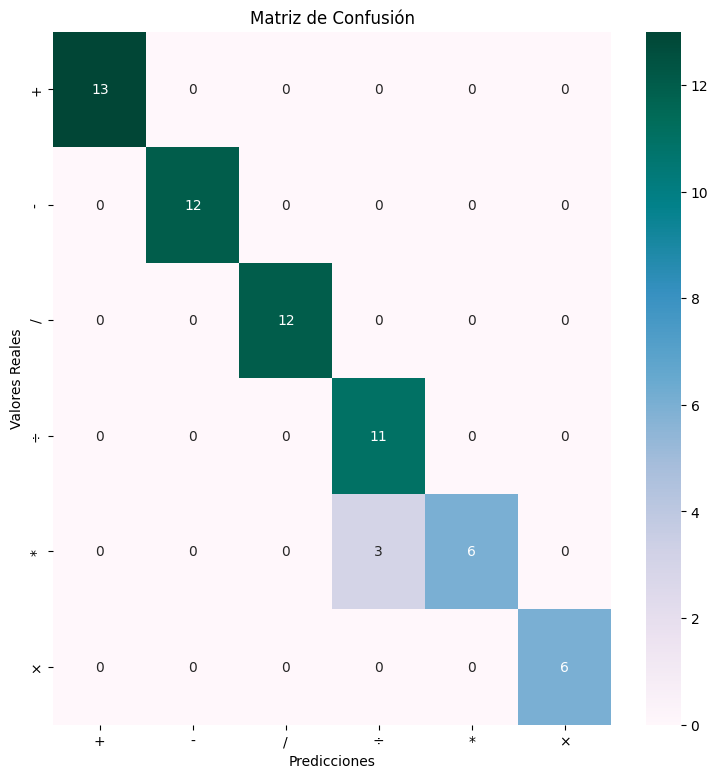

In [28]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_SVM, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = ['+', '-', '/', '÷', '*', '×'],
    yticklabels = ['+', '-', '/', '÷', '*', '×']
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Por último, se toma una muesra aleatoria de 8 imágenes extraídas del conjunto de prueba, se muestran sus valores reales y la predicción realizada por el modelo.

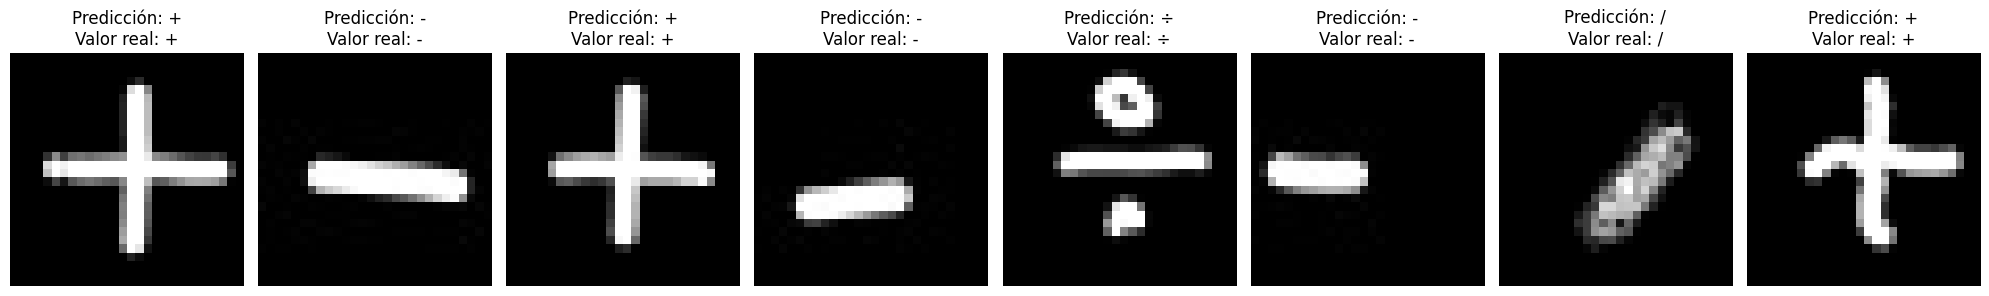

In [29]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {chr(y_pred_SVM[index])}\nValor real: {chr(y_test[index])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusiones

Una vez finalizadas las pruebas con los modelos, se debe elegir uno de ellos para utilizarlo en la aplicación a desarrollar con StreamLit, en esta sección se realiza dicha elección y se justifica la misma.

---

### Reportes

A continuación se hace una comparación de métricas entre los 3 modelos utilizados, para esto haremos uso de la herramienta [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

In [30]:
from sklearn.metrics import classification_report

print(f"Reporte de Regresión Logística:\n{classification_report(y_test, y_pred_LR)}\n")
print(f"Reporte de K-Vecinos:\n{classification_report(y_test, y_pred_KNN)}\n")
print(f"Reporte de SVM:\n{classification_report(y_test, y_pred_SVM)}\n")

Reporte de Regresión Logística:
              precision    recall  f1-score   support

          42       1.00      0.92      0.96        13
          43       1.00      1.00      1.00        12
          45       0.85      0.92      0.88        12
          47       0.79      1.00      0.88        11
         215       1.00      0.67      0.80         9
         247       1.00      1.00      1.00         6

    accuracy                           0.92        63
   macro avg       0.94      0.92      0.92        63
weighted avg       0.93      0.92      0.92        63


Reporte de K-Vecinos:
              precision    recall  f1-score   support

          42       1.00      0.85      0.92        13
          43       0.92      1.00      0.96        12
          45       0.86      1.00      0.92        12
          47       0.85      1.00      0.92        11
         215       1.00      0.67      0.80         9
         247       1.00      1.00      1.00         6

    accuracy          

Podemos observar que, al igual que el reconocimiento de dígitos, el modelo con mejor rendimiento es SVM, seguido por KNN con una diferencia de apróximadamente 4%.

### Tiempos de respuesta

De igual manera se proceden a comparar los tiempos de respuesta de cada modelo al momento de realizar una **única** predicción:

In [31]:
#Regresión Logística
start_time_uLR = time.time()
y_pred_LR = modelLR.predict(X_test[0].reshape(1, -1))
end_time_uLR = time.time()

pred_time_uLR = end_time_uLR - start_time_uLR

#KNN
start_time_uKNN = time.time()
y_pred_KNN = modelKNN.predict(X_test[0].reshape(1, -1))
end_time_uKNN = time.time()

pred_time_uKNN = end_time_uKNN - start_time_uKNN

#SVM
start_time_uSVM = time.time()
y_pred_SVM = modelSVM.predict(X_test[0].reshape(1, -1))
end_time_uSVM = time.time()

pred_time_uSVM = end_time_uSVM - start_time_uSVM

print(f"Tiempo de predicción de Regresión Logística: {pred_time_uLR:.5f} segundos")
print(f"Tiempo de predicción de K-NearestNeighbors: {pred_time_uKNN:.5f} segundos")
print(f"Tiempo de predicción de SupportVectorMachine: {pred_time_uSVM:.5f} segundos")

Tiempo de predicción de Regresión Logística: 0.00222 segundos
Tiempo de predicción de K-NearestNeighbors: 0.00308 segundos
Tiempo de predicción de SupportVectorMachine: 0.00137 segundos


Y se repite la comparación, esta vez con el tiempo que le toma a cada modelo realizar **múltiples** predicciones:

In [32]:
#Regresión Logística
print(f"Tiempo de predicción de Regresión Logística: {pred_time_LR * 8:.5f} segundos")
#KNN
print(f"Tiempo de predicción de K-NearestNeighbors: {pred_time_KNN * 8:.5f} segundos")
#SVM
print(f"Tiempo de predicción de SupportVectorMachine: {pred_time_SVM * 8:.5f} segundos")

Tiempo de predicción de Regresión Logística: 0.00676 segundos
Tiempo de predicción de K-NearestNeighbors: 0.06453 segundos
Tiempo de predicción de SupportVectorMachine: 0.18112 segundos


Es por estos resultados y las experiencias obtenidas al momento de realizar el notebook que se llegó a la conclusión de que el modelo que se debe almacenar para ser usado en la aplicación de StreamLit es KNN, ya que su precisión es tan solo un 1% menor que SVM pero el tiempo de respuesta al momento de realizar múltiples predicciones es muchísimo menor, lo cual me parece de vital importancia de cara a la experiencia de usuario al momento de usar la aplicación.

## Almacenamiento del modelo

En esta sección final se encuentra el código empleado para almacenar el modelo elegido en Google Drive.

---

Primero se importa la librería [joblib](https://joblib.readthedocs.io/en/stable/) y se monta la unidad de Drive donde se va guardar el modelo.

In [34]:
import joblib as jb
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Por último, se define una ruta y se almacena allí el modelo.

In [35]:
#Ruta para almacenar el modelo
root = '/content/drive/MyDrive/ML/SVM_Operadores.joblib'

jb.dump(modelKNN, root)

print(f"Modelo guardado en {root}")

Modelo guardado en /content/drive/MyDrive/ML/SVM_Operadores.joblib
